In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from random import uniform

In [2]:
def reflect(points: list, p1: list, p2: list) -> list:
    """reflect all points across the line that goes through p1 and p2
    
    @param  points - (list[list[real]]) each element is of the form [x, y]
    @param  p1 - (list[real]) point in R2
    @param  p2 - (list[real]) point in R2, distinct from p1
    @return (list[list[real]]) reflected points
    """
    if p1[0] == p2[0]:  # line is vertical
        return [[2 * p1[0] - x[0], x[1]] for x in points]
    
    # information about the line across which 'points' are reflected
    grad = (p2[1] - p1[1]) / (p2[0] - p1[0])  # slope of line
    y_int = p1[1] - grad * p1[0]              # y-intercept of line
    
    answer = []
    for x in points:
        new_x = (x[0] * (1 - grad ** 2) + 2 * grad * (x[1] - y_int)) / (1 + grad ** 2)
        new_y = (x[1] * (grad ** 2 - 1) + 2 * (grad * x[0] + y_int)) / (1 + grad ** 2)
        answer.append([new_x, new_y])
    return answer

In [3]:
def reformat_cells(cells: list, generators: list) -> list:
    """reformat 'cells' into a format compatible with other functions
    
    @param  cells - (?) cells given by voronoi()
    @return (list[list[list[real]]]) list of cells; 
            each cell consists of a list of triangles; 
            each triangle consists of list of vertices in counter-clockwise order
    """
    answer = []
    for i, cell in enumerate(cells):
        # note the generator of the current cell
        gen = generators[i]
        
        # sort the vertices of the cell/polygon in counter-clockwise order
        # using the inverse tangent function as key
        curr = sorted(cell, key = lambda p : np.arctan2(p[1] - gen[1], p[0] - gen[0]))
        
        # every adjacent pair of elements in 'curr' plus the generator
        # form a triangle in the correct orientation; just gather them up here
        temp = [[gen, curr[i], curr[i - 1]] for i in range(1, len(curr))]
        temp.append([gen, curr[0], curr[-1]])
        answer.append(temp)
        
    return answer

In [4]:
def voronoi(domain: list, generators: list):
    """find the Voronoi cells given generators within a domain
    
    @param  domain - (list[list[real]]) vertices of a polygon
    @param  generators - (list[list[real]]) each element is of the form [x, y]
    @return (list[list[real]]) list of new generators of the form [x, y]
    """
    original_length = len(generators)
    
    # TODO -- change this to only reflecting boundary points 
    # (maybe have benchmark of 20 points - if more than 20 points, then only reflect boundary)
    # reflect all points across boundaries
    temp = []
    for p1, p2 in zip(domain, domain[1:] + [domain[0]]):
        temp.extend(reflect(generators, p1, p2))
    
    # maybe just return the Voronoi object
    return Voronoi(generators + temp)

In [5]:
# Hard-coded points and weights for Gaussian quadrature
# TODO -- find points and weights for higher order precision
POINTS_X = [1/3, 1/5, 3/5, 1/5]
POINTS_Y = [1/3, 1/5, 1/5, 3/5]
WEIGHTS = [-27/96, 25/96, 25/96, 25/96]


def integrate(domain: list, function) -> float:
    """integrate 'function' over 'domain' that is a triangle in R2
    
    @param  domain - (list[list[real]]) three vertices of a triangle
    @param  function - (lambda real, real) function to be integrated
    @param  (real) result evaluated using Gaussian quadrature
    
    Change of variable: use standard basis vectors e1, e2.
    If the domain is [[a1, a2], [b1, b2], [c1, c2]], then the transformation is
        x = (b1 - a1) * e1 + (c1 - a1) * e2 + a1
        y = (b2 - a2) * e1 + (c2 - a2) * e2 + a2
    The Jacobian of this transformation is
        [[b1 - a1, c1 - a1], 
         [b2 - a2, c2 - a2]]
    The determinant of the Jacobian is
        (b1 - a1) * (c2 - a2) - (b2 - a2) * (c1 - a1)
    """
    a, b, c = domain[0], domain[1], domain[2]
    jacobian = (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
    
    # Gaussian quadrature with variable-changed function
    return sum(jacobian * w * function((b[0] - a[0]) * u + (c[0] - a[0]) * v + a[0], 
                                       (b[1] - a[1]) * u + (c[1] - a[1]) * v + a[1]) 
               for u, v, w in zip(POINTS_X, POINTS_Y, WEIGHTS))

In [6]:
def get_centroid(cells: list, density) -> list:
    """compute and return the centroid of each cell
    
    @param  cells - (list[list[list[real]]]) represents the cells; 
                    each element is the set of triangles that make up the cell
    @param  density - (lambda real, real) density function over the overall domain
    @return (list[list[real]]) new generators which are centroids of cells
    
    To compute the centroid of a given cell which is a polygon, 
        we split the cell into triangles and integrate each triangle.
    The two coordinates are computed separately, then added to 'answer'
        that gathers all the centroids
    """
    answer = []
    for cell in cells:
        # find centroid of current 'cell'
        x = sum(integrate(triangle, lambda x, y : x * density(x, y)) 
                for triangle in cell)
        y = sum(integrate(triangle, lambda x, y : y * density(x, y)) 
                for triangle in cell)
        mass = sum(integrate(triangle, density) for triangle in cell)
        answer.append([x / mass, y / mass])
    return answer

In [7]:
def plot_voronoi(n: int, vor):
    for i in vor.point_region[:n]:
        ver = [vor.vertices[j] for j in vor.regions[i]]
        ver.append(ver[0])
        plt.plot(*zip(*ver))

In [8]:
def lloyd(n: int, domain: list, init: list, density, animate: bool = False) -> list:
    """Lloyd's method with domain, initial guess points, and density function
    
    @param  domain - (list[list[real]]) vertices of the polygon that is the domain
    @param  init - (list[list[real]]) initial guess for generators of Voronoi cells
    @param  density - (lambda real, real) density function over 'domain'
    @return (list[list[real]]) generators of Voronoi cells
    """
    curr = init
    for _ in range(100): # TODO -- some condition
        # reflect all points across all boundaries
        refl = []
        for p1, p2 in zip(domain, domain[1:] + [domain[0]]):
            refl.extend(reflect(curr, p1, p2))
        
        # construct Voronoi diagram with the original plus reflected points
        vor = Voronoi(curr + refl)
        
        # choose the regions that are within 'domain'
        cells = []
        for i in vor.point_region[:n]:
            cells.append([vor.vertices[j] for j in vor.regions[i]])
            
        # change the format of 'cells' to compute integrals
        cells = reformat_cells(cells, curr)
        
        # update 'curr' by obtaining the centroids of 'cells'
        curr = get_centroid(cells, density)
        
        # TODO -- plot cell for animation
        if animate:
            pass
            
    
    plot_voronoi(n, vor)
    plt.scatter(*zip(*curr))
        
    return curr

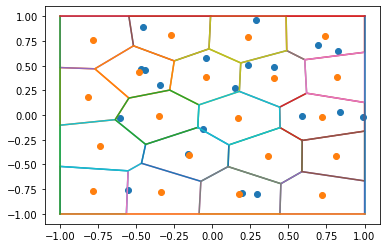

In [9]:
def exe_lloyd(n: int, domain: list, density = lambda x, y : 1) -> None:
    """main method for executing Lloyd's method
    
    @param  n - (int) number of generators
    @param  domain - (list[list[real]]) vertices of the polygon that is the domain
    @param  density - (lambda real, real) density function over 'domain'
    """
    
    # randomly generate 'n' points as generator
    init = [[uniform(-1, 1), uniform(-1, 1)] for _ in range(n)]
    plt.scatter(*zip(*init))
    
    # perform Lloyd's method and plot the resulting cells and generators
    result = lloyd(n, domain, init, density, True)
    
    # plot the domain polygon
    for p1, p2 in zip(domain, domain[1:] + [domain[0]]):
        plt.plot(p1, p2)
    
    
    
# testing
n = 20  # number of generators
domain = [[1, 1], [-1, 1], [-1, -1], [1, -1]]
density = lambda x, y : np.exp(-5 * abs(1 - x**2 - y**2))
exe_lloyd(n, domain)


# include options to animate the generators as well as cells
# stopping criterion: small enough gradient (* n)
# test density np.exp(-5 * |1 - x**2 - y**2|)



# change the reflection to only boundary points to be faster